Experimenting with structure of XGBoost algorithm including parameters, possible feature engineering, and most importantly, forecasting setup (masked input and evaluation)

In [21]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_recall_curve, roc_auc_score

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer

In [23]:

# Load the data
df = pd.read_csv('Dataset_1//10visit_combined.csv')

# Data preprocessing functions
def extract_first_value(x):
    """Extract first value from array-like strings"""
    if isinstance(x, str) and x.startswith('['):
        try:
            return float(x.split(',')[0].replace('[', '').strip())
        except:
            return np.nan
    return x

def create_target_variable(row):
    """Create target variable based on CDR scores (0=non-progressor, 1=progressor)"""
    id  = row['Prog_ID']
    
    return id

# Preprocess the data
def preprocess_data(df):
    # Create target variable
    df['target'] = df.apply(create_target_variable, axis=1)
    
    # Select features - adjust based on your domain knowledge
    features = [
        'SEX', 'EDUC', 'ALCOHOL', 'BMI', 'MMSE', 'GDS', 'CDR', 'TOBAC30',
        'BILLS', 'TAXES', 'SHOPPING', 'GAMES', 'STOVE', 'MEALPREP', 'EVENTS',
        'PAYATTN', 'REMDATES', 'TRAVEL', 'NACCFAM', 'CVHATT', 'CVAFIB',
        'DIABETES', 'HYPERCHO', 'HYPERTEN', 'B12DEF', 'DEPD', 'ANX', 'NACCTBI',
        'SMOKYRS', 'RACE', 'age'
    ]
    
    # Extract first visit data (simplifying for initial model)
    for col in df.columns:
        if col in features and df[col].dtype == object:
            df[col] = df[col].apply(extract_first_value)
    
    # Handle missing values
    df = df[features + ['target']].copy()
    df = df.dropna(subset=features, how='all')
    
    # Convert categorical variables
    categorical_cols = ['SEX', 'NACCFAM', 'CVHATT', 'CVAFIB', 'DIABETES', 
                       'HYPERCHO', 'HYPERTEN', 'B12DEF', 'DEPD', 'ANX', 'NACCTBI', 'RACE']
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')
    
    return df

# Preprocess the data
processed_df = preprocess_data(df)

# Check class distribution
print("Class distribution:")
print(processed_df['target'].value_counts())

Class distribution:
target
0    146
1     39
Name: count, dtype: int64


In [24]:
def build_model(data):
    # Separate features and target
    X = data.drop('target', axis=1)
    y = data['target']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Scale numerical features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train XGBoost model
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)  # Handle class imbalance
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    
    return model, X.columns

# Build and evaluate the model
model, feature_names = build_model(processed_df)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        29
           1       1.00      0.62      0.77         8

    accuracy                           0.92        37
   macro avg       0.95      0.81      0.86        37
weighted avg       0.93      0.92      0.91        37


ROC AUC Score: 0.7284


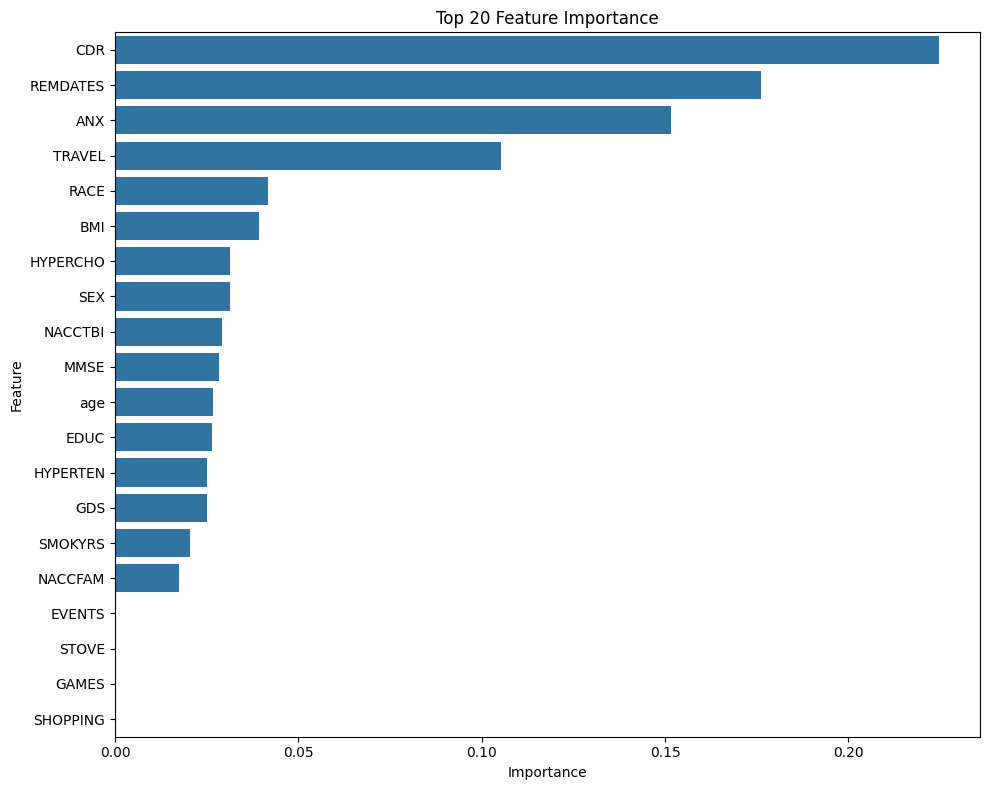

In [25]:
def plot_feature_importance(model, feature_names):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Get feature importance
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Top 20 Feature Importance')
    plt.tight_layout()
    plt.show()

# Plot feature importance
plot_feature_importance(model, feature_names)